In [61]:
import os, sys, importlib, logging, random, traceback

import numpy as np
import pandas as pd
import scipy as sp
from scipy.interpolate import griddata, RBFInterpolator
from scipy.spatial import cKDTree

from sklearn.preprocessing import QuantileTransformer
import skgstat as skg
from skgstat import models

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LightSource
from matplotlib.path import Path
from matplotlib.lines import Line2D
import matplotlib.ticker as mticker
import seaborn as sns
sns.set_theme()

from pyproj import Transformer
import cartopy.crs as ccrs
import cartopy
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
proj_3413 = ccrs.epsg(3413)

import netCDF4

import gstatsim as gs
import gstatsim_custom as gsim
from gstatsim_custom import interpolate
importlib.reload(interpolate)

# Logging setup (tweak level/format as needed)
logging.basicConfig(level=logging.DEBUG, format='%(asctime)s -%(levelname)s -on line: %(lineno)d -%(message)s')
logger = logging.getLogger('name')

In [62]:
core3_df = pd.read_csv('data/3cores.csv')
X_ls = []
Y_ls = []
for i in range(len(core3_df)):
    y_coord, x_coord = float(core3_df.at[i, 'lon']), float(core3_df.at[i, 'lat'])
    x_trans, y_trans = transformer.transform(x_coord, y_coord)
    print(x_trans, y_trans)
    X_ls.append(x_trans)
    Y_ls.append(y_trans)
core3_df['X'] = X_ls
core3_df['Y'] = Y_ls

-2455220.3799470863 -38000.81804313284
-2371888.528769009 -52445.09291899725
-2278114.069881762 13551.881451109522
-2277803.2021601065 13583.189167793638
-2257659.5402246974 117803.06274523145


In [47]:
transects = pd.read_csv('data/delta_transects.csv')
transect = transects[transects['id']==2]

In [52]:
#update core with correction
core3_df['corrected_elevation'] = core3_df['depth_rsl'] - correction

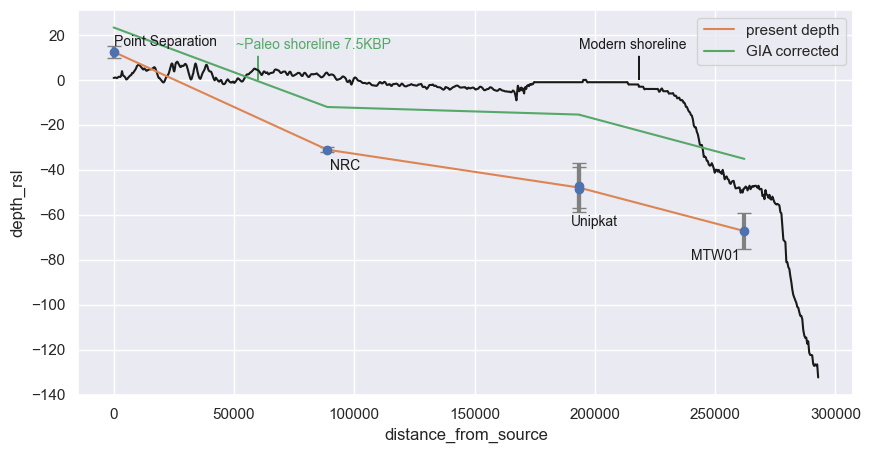

In [53]:
fig, ax = plt.subplots(figsize=(10,5))

ax.plot(transect['dist_km']*1000, transect['Z'],c='k')
ax.errorbar(core3_df['distance_from_source'], core3_df['depth_rsl'], yerr=core3_df['elevation_error'],
            ecolor='grey', elinewidth=3,fmt='o',capsize=5)
sns.lineplot(x='distance_from_source', y='depth_rsl',data=core3_df, ax=ax, label="present depth")
sns.lineplot(x='distance_from_source', y='corrected_elevation',data=core3_df, ax=ax, label="GIA corrected")
ax.text(0, 15, 'Point Separation', fontsize=10, color='k')
ax.text(90000, -40, 'NRC', fontsize=10, color='k')
ax.text(190000, -65, 'Unipkat', fontsize=10, color='k')
ax.text(240000, -80, 'MTW01', fontsize=10, color='k')
ax.text(core3_df['distance_from_source'][3], 14, 'Modern shoreline', fontsize=10, color='k')
ax.arrow(core3_df['distance_from_source'][3]+25000, 0, 10, 10, head_width=1, head_length=1, fc='k', ec='k')
ax.text(51000, 14, '~Paleo shoreline 7.5KBP', fontsize=10, color='g')
ax.arrow(60000, 0, 10, 10, head_width=1, head_length=1, fc='g', ec='g')


# plt.grid(axis='x')

In [87]:
fig.savefig("analysis_transect.png", dpi=300, bbox_inches='tight')

# Resampling and creating a uniform grid

The following section is for preparing topo data with customized resolution for plotting and data interpolating

In [48]:
topo = pd.read_csv('data/combined_topo_bathy.csv')
with netCDF4.Dataset('data/Gi31_H_grid.nc', 'r') as ds:
    time = ds.variables['time'][:]
    time_index = np.where((time == 7.5))[0][0]
    RSL = ds.variables['RSL'][:][time_index].T
    R = ds.variables['R_latlong'][:][time_index].T
    lon = ds.variables['lon'][:]
    lat = ds.variables['lat'][:]
lon_grid, lat_grid = np.meshgrid(lon, lat)
print(RSL.shape)
lon_min, lon_max = 200, 250
lat_min, lat_max = 62, 75

(256, 512)


In [49]:
ymin, ymax = min(topo['Y']), max(topo['Y'])
xmin, xmax = min(topo['X']), max(topo['X'])
coord1 = transformer_revert.transform(xmin,ymin)
coord2 =  transformer_revert.transform(xmax,ymax)
Ylim = [ymin,ymax]
Xlim = [xmin,xmax]
print(Ylim)
print(Xlim)
print(coord1)
print(coord2)
# creating uniform grid
res = 300
x = np.linspace(Xlim[0], Xlim[1], res)
y = np.linspace(Ylim[0], Ylim[1], res)
X,Y = np.meshgrid(x, y)

[-173176.037, 178831.926]
[-2541984.99, -2126921.783]
(66.78970604456018, -131.10267239633112)
(70.47990090425097, -139.80613402736836)


In [50]:
# Flatten the topo grid and Z data for interpolation
points = np.column_stack((topo['X'].to_numpy(), topo['Y'].to_numpy()))
values = topo['Z'].to_numpy()
topo_interpolated = griddata(points, values, (X, Y), method='cubic')

points = np.column_stack((core3_df['X'].to_numpy(), core3_df['Y'].to_numpy()))
values = core3_df['depth_rsl'].to_numpy()
core3_interpolated = griddata(points, values, (X, Y), method='linear')

lon_flat = lon_grid.ravel()
lat_flat = lat_grid.ravel()
x_flat, y_flat = transformer.transform(lat_flat, lon_flat)
x_grid = x_flat.reshape(lon_grid.shape)
y_grid = y_flat.reshape(lat_grid.shape)
points = np.column_stack((x_grid.ravel(), y_grid.ravel()))
values = RSL.ravel()
RSL_interpolated = griddata(points, values, (X, Y), method='cubic')

In [51]:
points = np.column_stack((X.ravel(), Y.ravel()))
values = RSL_interpolated.ravel()
tree = cKDTree(points)
queries = np.column_stack([core3_df['X'], core3_df['Y']])
d, idx = tree.query(queries, k=1)
correction = values[idx]
# print(correction)

In [54]:
points = np.column_stack((core3_df['X'].to_numpy(), core3_df['Y'].to_numpy()))
values = core3_df['corrected_elevation'].to_numpy()
core3_corrected_interpolated = griddata(points, values, (X, Y), method='linear')

points = np.column_stack((X.ravel(), Y.ravel()))
values = core3_corrected_interpolated.ravel()
core3_corrected_interpolated_1 = griddata(points, values, (X, Y), method='nearest')

In [55]:
def demo_locatable_axes_easy(ax, im):
    from mpl_toolkits.axes_grid1 import make_axes_locatable

    divider = make_axes_locatable(ax)

    ax_cb = divider.append_axes("right", size="5%", pad=0.05)
    fig = ax.get_figure()
    fig.add_axes(ax_cb)

    # Z, extent = get_demo_image()
    # im = ax.imshow(Z, extent=extent)

    plt.colorbar(im, cax=ax_cb)
    ax_cb.yaxis.tick_right()
    ax_cb.yaxis.set_tick_params(labelright=True)

2025-11-04 11:05:54,464 -DEBUG -on line: 867 -locator: <matplotlib.ticker.FixedLocator object at 0x16be215b0>
2025-11-04 11:05:54,466 -DEBUG -on line: 867 -locator: <matplotlib.ticker.FixedLocator object at 0x16be90410>


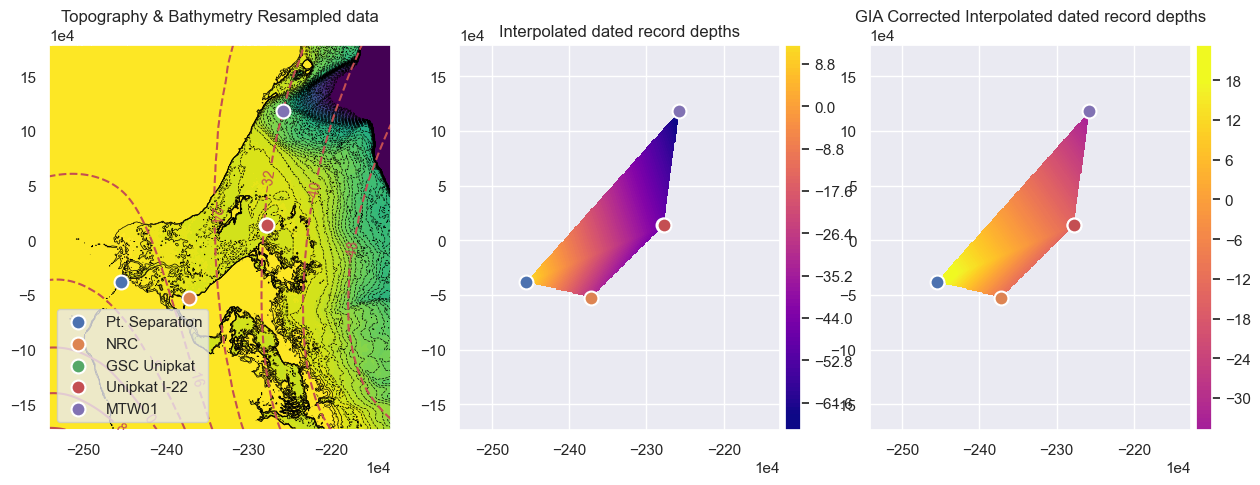

In [56]:
from matplotlib.ticker import ScalarFormatter
# fig, ax = plt.subplots(figsize=(10,10))
vmin = -200
vmax= 10
fig, ax = plt.subplots(1,3,figsize=(15,5))

ax[0].contourf(X, Y, topo_interpolated, 1000,cmap='viridis', vmin=vmin, vmax=vmax, zorder=1)
ax[0].contour(X, Y, topo_interpolated, levels=np.linspace(vmin, vmax, 50), colors='black', linewidths=0.5, zorder=2)
cs = ax[0].contour(X,Y,RSL_interpolated,10, colors='r')
im = ax[1].contourf(X,Y,core3_interpolated,100, cmap='plasma', vmin=-64, vmax=18)
im1 = ax[2].contourf(X,Y,core3_corrected_interpolated,100, cmap='plasma',vmin=-64, vmax=18)
for i in range(len(core3_df)):
    ax[0].scatter(core3_df['X'][i],core3_df['Y'][i], zorder=3,edgecolor='w', s=100,linewidth=1.5, label=core3_df['name'][i])
    ax[1].scatter(core3_df['X'][i],core3_df['Y'][i], zorder=3,edgecolor='w', s=100,linewidth=1.5, label=core3_df['name'][i])
    ax[2].scatter(core3_df['X'][i],core3_df['Y'][i], zorder=3,edgecolor='w', s=100,linewidth=1.5, label=core3_df['name'][i])
    ax[0].ticklabel_format(axis='both', style='sci', scilimits=(4,4))
    ax[1].ticklabel_format(axis='both', style='sci', scilimits=(4,4))
    ax[2].ticklabel_format(axis='both', style='sci', scilimits=(4,4))
ax[0].clabel(cs, fontsize=10)
ax[0].set_title('Topography & Bathymetry Resampled data')
ax[1].set_title('Interpolated dated record depths')
ax[2].set_title('GIA Corrected Interpolated dated record depths')
demo_locatable_axes_easy(ax[1], im)
demo_locatable_axes_easy(ax[2], im1)

ax[0].legend(loc='lower left')


fig.show()

# Using Gstatsim for Bedmap interpolation

The following section will set up conditioning data and statistically simulate the outer perimiter GIA corrected to create a base topography.

The base topography will then be masked and subtracted from the present topo to estimate the sediment volume

2025-11-04 11:06:00,574 -DEBUG -on line: 867 -locator: <matplotlib.ticker.AutoLocator object at 0x16f3fd0a0>


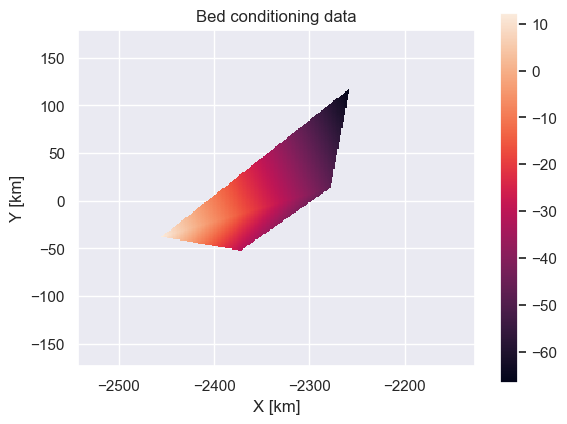

In [57]:
# re using plotted data above to clearly define matrices that we will use
xx,yy = X,Y
bed_cond = core3_interpolated
plt.pcolormesh(x/1000, y/1000, bed_cond)
plt.axis('scaled')
plt.xlabel('X [km]')
plt.ylabel('Y [km]')
plt.title('Bed conditioning data')
plt.colorbar()
plt.show()


In [58]:
cond_msk = ~np.isnan(bed_cond)
x_cond = xx[cond_msk]
y_cond = yy[cond_msk]
data_cond = bed_cond[cond_msk]

smoothing = 1e10
interp = RBFInterpolator(np.array([x_cond, y_cond]).T, data_cond, smoothing=smoothing)
trend = interp(np.array([xx.flatten(), yy.flatten()]).T).reshape(xx.shape)
res_cond = bed_cond - trend

2025-11-04 11:06:24,659 -DEBUG -on line: 867 -locator: <matplotlib.ticker.AutoLocator object at 0x16f62a8d0>
2025-11-04 11:06:24,671 -DEBUG -on line: 867 -locator: <matplotlib.ticker.AutoLocator object at 0x16f62b1d0>


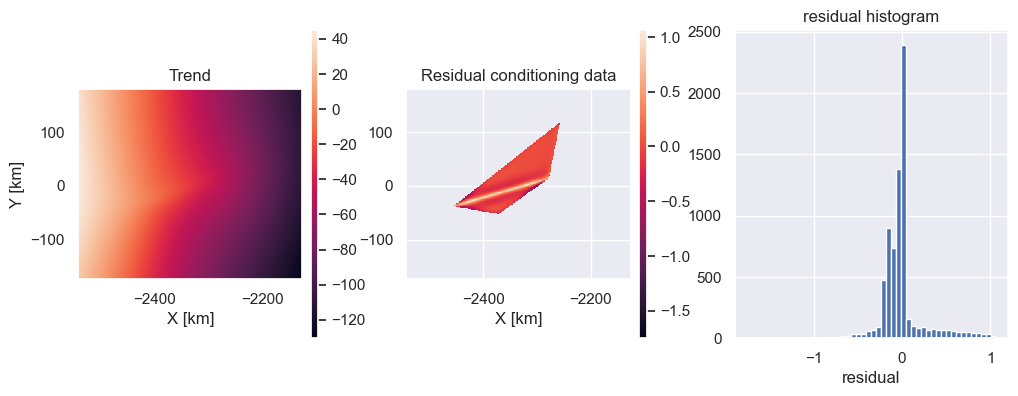

In [59]:
fig, axs = plt.subplots(1, 3, figsize=(12,4))
ax = axs[0]
im = ax.pcolormesh(x/1000, y/1000, trend)
ax.axis('scaled')
ax.set_xlabel('X [km]')
ax.set_ylabel('Y [km]')
ax.set_title('Trend')
plt.colorbar(im, ax=ax, pad=0.03, aspect=40)

ax = axs[1]
im = ax.pcolormesh(x/1000, y/1000, res_cond)
ax.axis('scaled')
ax.set_xlabel('X [km]')
ax.set_title('Residual conditioning data')
plt.colorbar(im, ax=ax, pad=0.03, aspect=40)

ax = axs[2]
ax.hist(res_cond[cond_msk], bins=50)
ax.set_xlabel('residual')
ax.set_title('residual histogram')

plt.show()

In [63]:
res_norm, nst_trans = gsim.utilities.gaussian_transformation(res_cond, cond_msk)
df_grid = pd.DataFrame({'X' : x_cond, 'Y' : y_cond, 'residual' : res_cond[cond_msk], 'NormZ' : res_norm[cond_msk]})

AttributeError: module 'gstatsim_custom' has no attribute 'utilities'

In [ ]:
vgrams, experimental, bins = variograms(xx, yy, res_cond, maxlag=30e3, n_lags=10, downsample=5)

In [ ]:
# evaluate models
xi =np.linspace(0, bins[-1], 100) 

y_exp = models.exponential(xi, *vgrams['exponential'])
y_gauss = models.gaussian(xi, *vgrams['gaussian'])
y_sph = models.spherical(xi, *vgrams['spherical'])
y_matern = models.matern(xi, *vgrams['matern'])

In [ ]:
plt.figure(figsize=(6,4))
plt.scatter(bins, experimental, s=12, c='k')
plt.plot(xi, y_exp, label='exp')
plt.plot(xi, y_gauss, label='gauss')
plt.plot(xi, y_sph, label='sph')
plt.plot(xi, y_matern, label='matern')
plt.title('Isotropic Experimental Variogram')
plt.xlabel('Lag (m)'); plt.ylabel('Semivariance')
plt.legend()
plt.show()

In [ ]:
vgrams['matern']

In [ ]:
parameters = vgrams['matern']

# set variogram parameters
nugget = parameters[-1]
major_range = parameters[0]
minor_range = parameters[0]
sill = parameters[1]
smoothness = parameters[2]
nugget = parameters[-1]
azimuth = 0

In [ ]:
rng = np.random.default_rng(0)

k = 10
rad = 240e3

In [ ]:
# save variogram parameters as a list
vario_list = [azimuth, nugget, major_range, minor_range, sill, 'matern', smoothness]

pred_grid = np.stack([xx.flatten(), yy.flatten()]).T
sim = gs.Interpolation.okrige_sgs(pred_grid, df_grid, 'X', 'Y', 'NormZ', k, vario_list, rad, quiet=False, seed=0)
sim_trans = nst_trans.inverse_transform(sim.reshape(-1,1)).squeeze()

In [ ]:
res_sim_gsm = sim_trans.reshape(xx.shape)
bed_gsm = res_sim_gsm + trend

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10,5), sharey=True)
ax = axs[0]
im = ax.pcolormesh(x/1000, y/1000, res_sim_gsm)
ax.axis('scaled')
ax.set_xlabel('X [km]')
ax.set_ylabel('Y [km]')
ax.set_title('GStatSim simulation')
plt.colorbar(im, ax=ax, pad=0.03, aspect=40)

ax = axs[1]
im = ax.pcolormesh(x/1000, y/1000, bed_gsm)
ax.axis('scaled')
ax.set_xlabel('X [km]')
ax.set_title('GStatSim simulation + trend')
plt.colorbar(im, ax=ax, pad=0.03, aspect=40)
plt.show()

In [ ]:
df_boundary = pd.read_csv('mackenzie-boundary.csv')
delta = df_boundary[df_boundary['id'] == 2]
offshore = df_boundary[df_boundary['id'] == 7]
mask1 = Path(np.column_stack((delta['X'],delta['Y'])))
mask2 = Path(np.column_stack((offshore['X'],offshore['Y'])))
inside_delta = mask1.contains_points(points)
inside_shore = mask2.contains_points(points)
inside_combined = np.logical_or(inside_delta, inside_shore)
bed_raveled = bed_gsm.ravel()
topo_raveled = topo_interpolated.ravel()
masked_bed_sim = bed_raveled[inside_combined]
masked_topo = topo_raveled[inside_combined]
masked_coords = points[inside_combined]

sediment_thickness = masked_topo - masked_bed_sim
filtered_H_thickness = np.where(sediment_thickness < 0, 0, sediment_thickness)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10,5), sharey=True)
ax1 = axs[0]
im = ax1.pcolormesh(x/1000, y/1000, bed_gsm)
ax1.axis('scaled')
ax1.set_xlabel('X [km]')
ax1.set_ylabel('Y [km]')
ax1.set_title('GStatSim simulation + trend')
plt.colorbar(im, ax=ax1, pad=0.03, aspect=40)

ax2 = axs[1]
im1 = ax2.scatter(masked_coords[:, 0]/1000, masked_coords[:, 1]/1000, c=filtered_H_thickness, cmap='Greens', s=1)

# ax2.plot(delta['X']/1000, delta['Y']/1000, color='green', linewidth=1)
# ax2.plot(offshore['X']/1000, offshore['Y']/1000, color='green', linewidth=1)
ax2.axis('scaled')
ax2.set_xlabel('X [km]')
ax2.set_title('Thickness')
for i in range(len(core3_df)):
    ax1.scatter(core3_df['X'][i]/1000,core3_df['Y'][i]/1000, zorder=3,edgecolor='w', s=100,linewidth=1.5, label=core3_df['name'][i])
    ax2.scatter(core3_df['X'][i]/1000,core3_df['Y'][i]/1000, zorder=3,edgecolor='w', s=100,linewidth=1.5, label=core3_df['name'][i])

plt.colorbar(im1, ax=ax2, pad=0.03, aspect=40)
plt.show()

# Estimate total sediment volume

In [ ]:
V_estimated = np.sum(filtered_H_thickness)
print(f"V_total = {V_estimated} m^3")
print(f"Yearly sedimentation past 7.5KBP= {V_estimated/7500} m^3/yr")